## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [2]:
df = pd.read_csv('https://ds.codeup.com/saas.csv')

In [3]:
df

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
# Create new column called ds, sort by ds column, and set as index
# drop Month_Invoiced column

df = df.assign(ds = pd.to_datetime(df.Month_Invoiced)).sort_values('ds').set_index('ds').drop(columns=['Customer_Id', 'Invoice_Id', 'Month_Invoiced'])

# Remove leap day
df = df[df.index != '2016-02-29']

## Split
- Resample by week

In [6]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .5)

# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)

# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)
train_size, validate_size, test_size

(387219, 232331, 154889)

In [7]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

619550

In [8]:
# split into train, validation, test
train = df[ : train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [9]:
train.shape, validate.shape, test.shape

((387219, 2), (232331, 2), (154889, 2))

In [10]:
train.head()

,Subscription_Type,Amount
ds,,
2014-01-31,0.0,0.0
2014-01-31,0.0,0.0
2014-01-31,0.0,0.0
2014-01-31,0.0,0.0
2014-01-31,1.0,5.0


In [11]:
# check if split datasets = original dataframe
len(train) + len(validate) + len(test) == len(df)

True

In [12]:
# test the row starts
print(df.head(1) == train.head(1))

            Subscription_Type  Amount
ds                                   
2014-01-31               True    True


In [14]:
train = train.resample('W').sum()
validate = validate.resample('W').sum()
test = test.resample('W').sum()

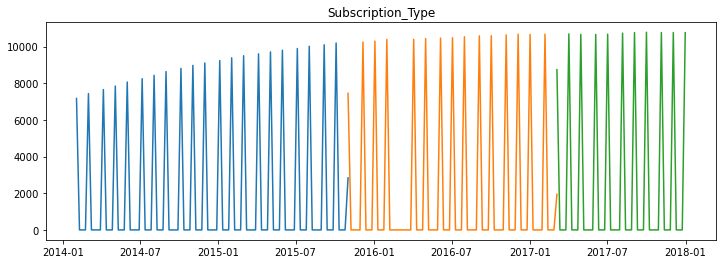

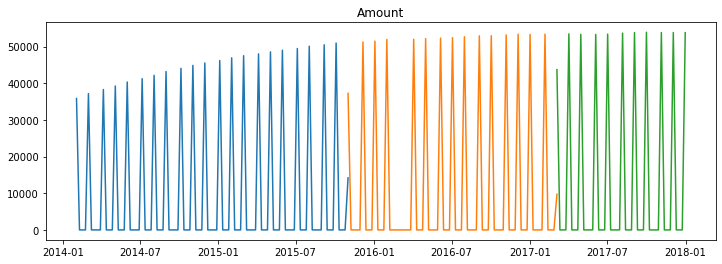

In [15]:
def plot_samples(target_var):
    """
    Function plots target variable from train, validate, and test datasets
    """
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)
for col in train.columns:
    plot_samples(col)

In [16]:
# define evaluation function to compute rmse

def evaluate(target_var):
    """
    the evaluate function takes in actual and predicted values in validate,
    computes mean_squared_error and takes sqrt and rounds to a whole number
    Returns rmse as an integer
    """
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [17]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

# check out the data frame
eval_df

,model_type,target_var,rmse


In [18]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    Function takes in model_type and target_var as strings and runs evaluate function
    to compute rmse, and appends to the dataframe a row with the model type, target var and rmse.
    Returns new dataframe.
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [19]:
# Define function to store predictions in dataframe
def make_predictions():
    yhat_df = pd.DataFrame({'Subscription_Type': [sub_type],
                            'Amount': [amount],
                           }, index = validate.index)
    return yhat_df

#### Simple Average

In [20]:
sub_type = round(train.Subscription_Type.mean(), 0)
amount = round(train.Amount.mean(), 0)

yhat_df = make_predictions()
yhat_df.head(2)

,Subscription_Type,Amount
ds,,
2015-11-01,2073.0,10366.0
2015-11-08,2073.0,10366.0


Subscription_Type -- RMSE: 4215


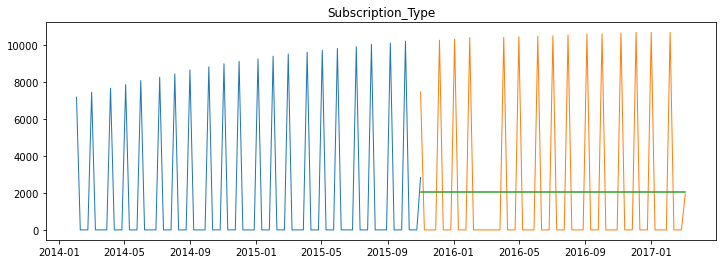

Amount -- RMSE: 21077


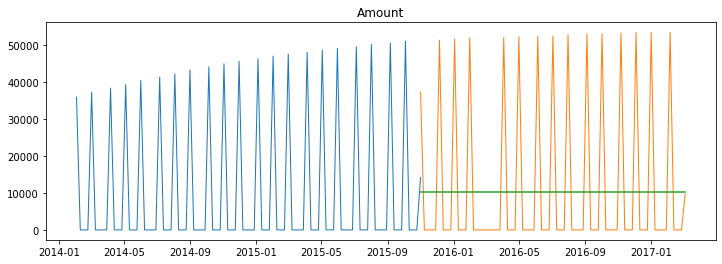

In [21]:
for col in train.columns:
    plot_and_eval(col)

In [22]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_avg', target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_avg,Subscription_Type,4215.0
1,simple_avg,Amount,21077.0


### Moving Average

In [23]:
sub_type = round(train.Subscription_Type.rolling(2).mean().iloc[-1], 0)
amount = round(train.Amount.rolling(2).mean().iloc[-1], 0)

yhat_df = make_predictions()
yhat_df.head(2)

,Subscription_Type,Amount
ds,,
2015-11-01,1420.0,7098.0
2015-11-08,1420.0,7098.0


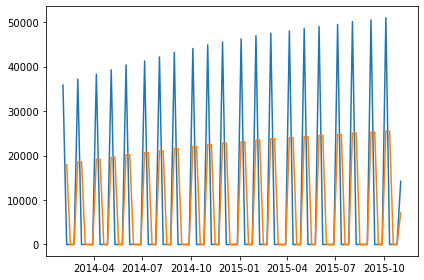

In [24]:
plt.plot(train['Amount'])
plt.plot(train.Amount.rolling(2).mean())
plt.tight_layout()

In [25]:
# crate a new yhat data frame with updated items and dollars values
yhat_df = make_predictions()
yhat_df.head(5)

,Subscription_Type,Amount
ds,,
2015-11-01,1420.0,7098.0
2015-11-08,1420.0,7098.0
2015-11-15,1420.0,7098.0
2015-11-22,1420.0,7098.0
2015-11-29,1420.0,7098.0


Subscription_Type -- RMSE: 4286


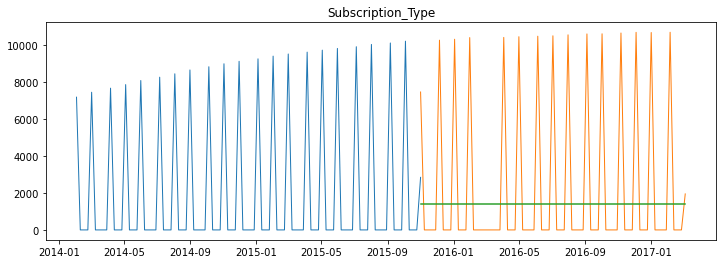

Amount -- RMSE: 21429


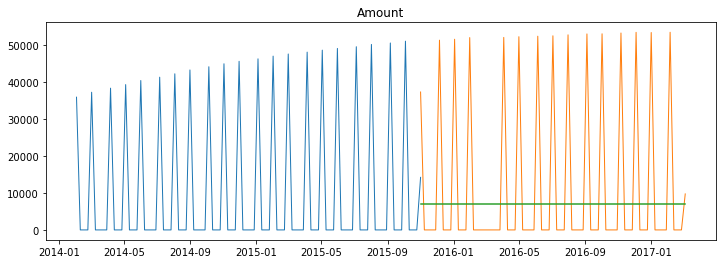

In [26]:
for col in train.columns:
    plot_and_eval(col)

In [27]:
# append the evaluation results to our eval_df for each target variable for comparison
for col in train.columns:
    eval_df = append_eval_df(model_type = '2W moving avg', target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_avg,Subscription_Type,4215.0
1,simple_avg,Amount,21077.0
2,2W moving avg,Subscription_Type,4286.0
3,2W moving avg,Amount,21429.0


In [28]:
periods = range(3, 11)

for p in periods:
    sub_type = round(train.Subscription_Type.rolling(p).mean().iloc[-1], 0)
    amount = round(train.Amount.rolling(p).mean().iloc[-1], 0)
    yhat_df = make_predictions()
    model_type = str(p) + 'W moving avg'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Subscription_Type'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Amount'
                            )
eval_df

,model_type,target_var,rmse
0,simple_avg,Subscription_Type,4215.0
1,simple_avg,Amount,21077.0
2,2W moving avg,Subscription_Type,4286.0
3,2W moving avg,Amount,21429.0
4,3W moving avg,Subscription_Type,4397.0
5,3W moving avg,Amount,21986.0
6,4W moving avg,Subscription_Type,4470.0
7,4W moving avg,Amount,22353.0
8,5W moving avg,Subscription_Type,4233.0
9,5W moving avg,Amount,21163.0


In [29]:
# get the min rmse for each variable
min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

In [30]:
# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
10,6W moving avg,Subscription_Type,4213.0
11,6W moving avg,Amount,21067.0


In [31]:
# Keep simple_avg, initial moving avg (2W), and best performing moving avg (9W)
eval_df = pd.concat([eval_df[:4], eval_df[16:18]])
eval_df

,model_type,target_var,rmse
0,simple_avg,Subscription_Type,4215.0
1,simple_avg,Amount,21077.0
2,2W moving avg,Subscription_Type,4286.0
3,2W moving avg,Amount,21429.0
16,9W moving avg,Subscription_Type,4229.0
17,9W moving avg,Amount,21146.0


### Holt's Linear Trend

In [39]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()
    plt.show()

Subscription_Type 



ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [ ]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    # fit the model providing alpha/smoothing level and beta/smoothing slope
    model = model.fit(smoothing_level=.1,
                     smoothing_slope=.1,
                     optimized=False)
    # predict forecast providing start and end date
    yhat = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat, 2)
yhat_df.head()

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type='Holts', target_var = col)
    plot_and_eval(target_var = col)

In [ ]:
eval_df

### Previous cycle

In [ ]:
# take the values for each month in 2015 and add the average Y.O.Y 
# difference to be our forecast
yhat_df = train + train.diff(13).mean()

# set yhat_df index to index of validate
yhat_df = yhat_df.set_index(validate.index)

yhat_df.head()

### Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.